***NOTE*** - You must have RDKit and tensor2tensor installed to use this tutorial. Documentation/installation instructions for each can be found at [https://www.rdkit.org/docs/GettingStartedInPython.html](https://www.rdkit.org/docs/GettingStartedInPython.html) and [https://github.com/tensorflow/tensor2tensor](https://github.com/tensorflow/tensor2tensor)

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ColorConverter

from transvae.tvae_util import *

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from collections import defaultdict
import rdkit
print(rdkit.__version__)

2020.09.1


In [2]:
from tensor2tensor.visualization import attention

In [3]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [4]:
%load_ext autoreload
%autoreload 2

import IPython.display as Disp
np.set_printoptions(suppress=True)

In [5]:
### Helper function
def align_smiles_w_mol(mol, smi):
    atom_chars = ['C', 'c', 'S', 'O', 'o', 'N', 'n', '[nH]', 'Cl', 'Br', 'F']
    smi = ['<bos>'] + smi_tokenizer(smi)
    molidx_2_smidx = {}
    at_names = []
    for at in mol.GetAtoms():
        at_names.append(at.GetSymbol())
    idx_tracker = 0
    for i, char in enumerate(smi):
        if char in atom_chars:
            molidx_2_smidx[i] = idx_tracker
            idx_tracker += 1
    return molidx_2_smidx, at_names

### Calculating Attention

Attention weights are unique to each molecular embedding and calculated during inference based on the model parameters learned during training. The `attention.py` script will calculate and save the weights for a trained model on a given set of SMILES strings. Attention weights are stored in a matrix with dimensions `[n_samples, n_layers, n_attention_heads, tok_seq1, tok_seq2]`. The `RNNAttn` models only have 1 layer and 1 attention head. The `Trans` models have 4 attention heads, 4 layers of self-attention and 3 layers of source-attention (connecting the encoder to the decoder). 

We will use a small set of pre-calculated weights for the `Trans4x-256` model to demonstrate visualizing attention on the first layer in the encoder.

In [6]:
# Load Weights and SMILES
smiles = pd.read_csv('example_data/zinc_smiles.txt').to_numpy()[:,0]
attn_wts = np.load('example_data/trans4x-256_attn_wts.npy')

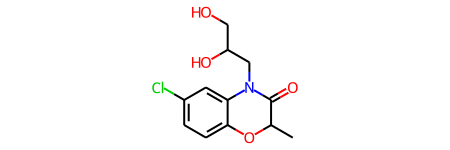

In [8]:
# Select Molecule
# This code calculates all necessary data for visualization
mol_idx = 4
smi = smiles[mol_idx]
mol = Chem.MolFromSmiles(smi)
m_2_s, at_names = align_smiles_w_mol(mol, smi) #this allows us to access specific atoms in RDKit representation
smi_toks = ['<bos>'] + smi_tokenizer(smi)
smi_label = smi_tokenizer(smi)
src = ['<bos>'] + smi_label
tgt = []
for i, tok in enumerate(src):
    tgt.append('{}_{}'.format(i, tok))
self_wt_ = attn_wts[mol_idx,:,:,:len(src),:len(src)]
self_wts = []
for i in range(self_wt_.shape[0]):
    self_wt = self_wt_[i,:,:,:]
    self_wts.append(self_wt)
mol

The code for visualizing attention is very simple. We pass the source SMILE and the self-attention weights. You must first select input-input or input-output from the attention drop down or else the visualization will be overwhelming. Only layer 0 is active, but we can view individual attention heads (blue, orange, green or red) by selecting or de-selecting them from the check boxes at the top. Mousing over specific tokens will also allow you to see the attention for just those tokens specifically.

In [9]:
# Visualizing attention
attention.show(src, tgt, self_wts, self_wts, self_wts)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We can visualize the weights between atom tokens directly by using the built in highlighting functionality of RDKits drawing tool. The atoms that are being attended to are colored by the respective attention head color and the atom that is attending to the tokens is colored in black. You may change the attn_head or atom_idx to visualize other relationships.

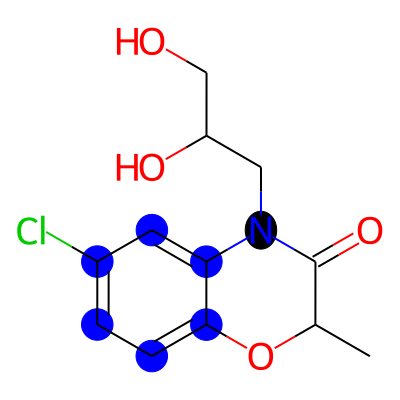

In [11]:
attn_head = 0
atom_idx = 16
atom_wts = self_wts[0][0,attn_head,:,atom_idx]
hit_ats = np.where(atom_wts > 1e-5)[0]

color_names = ['blue', 'orange', 'green', 'red', 'black']
colors = []
for name in color_names:
    colors.append(ColorConverter().to_rgb(name))
athighlights = defaultdict(list)
arads = {}
for at in hit_ats:
    at = int(at)
    if at in m_2_s.keys():
        sat = m_2_s[at]
        color = list(colors[attn_head])
        color.append(atom_wts[at])
        athighlights[sat].append(colors[attn_head])
        arads[sat] = float(atom_wts[at]) / 4
    else:
        pass

at = int(atom_idx)
if at in m_2_s.keys():
    sat = m_2_s[at]
    color = list(colors[-1])
    color.append(atom_wts[at])
    athighlights[sat].append(colors[-1])
    arads[sat] = 0.25

d2d = rdMolDraw2D.MolDraw2DSVG(400,400)
d2d.DrawMoleculeWithHighlights(mol,'',dict(athighlights),{},arads,{})
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
SVG(svg)